# Ball kolliderer med vegg

Vi modellerer en ball som kolliderer med en horisontal vegg ved $y = 0$.
Ballen skytes med en initiell hastighet $\mathbf v$ og gravitasjonsakselerasjonen $g$ virker nedover.

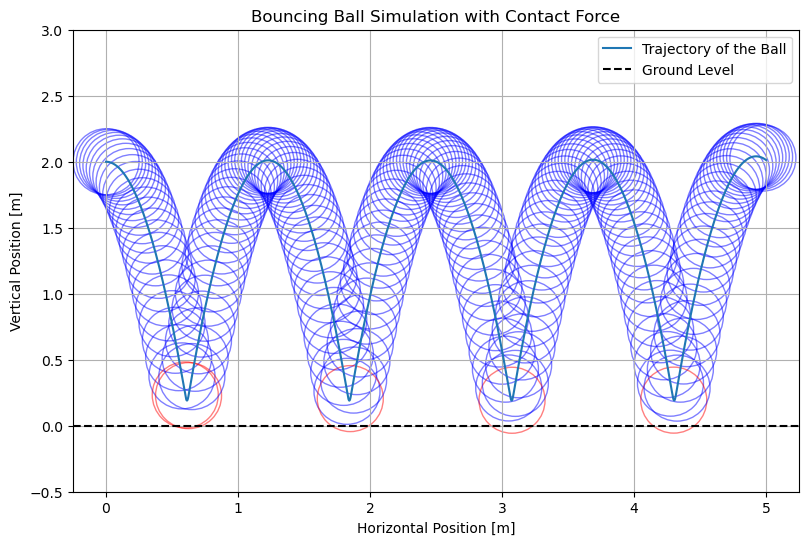

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Model the contact force as a linear spring
def contact_force(x, k=1000):
    return -k * x if x < 0 else 0

y0 = 2.0  # Initial height [m]
v0x = 1.0 # Initial horizontal velocity [m/s]
v0y = 0.0 # Initial vertical velocity [m/s]
g = 9.81  # Gravitational acceleration [m/s^2]
k = 10000  # "Spring" constant [N/m]
R = 0.25  # Radius of the ball [m]
m = 0.060  # Mass of the ball [kg]

# Define the system of ODEs
def system(t, y):
    vx, vy, x, y = y
    fx = 0
    fy = contact_force(y - R, k) - g
    return [fx, fy, vx, vy]

# Initial conditions
initial_conditions = [v0x, v0y, 0.0, y0]

# Time span for the simulation
t_span = (0, 5)
t_eval = np.linspace(t_span[0], t_span[1], 4000)

# Solve the ODEs
solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval)
vx, vy, x, y = solution.y

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, label='Trajectory of the Ball')
# Draw the ball at various time points
for i in range(0, len(t_eval), 20):
    circle = plt.Circle((x[i], y[i]), R, color='blue', fill=False, alpha=0.5)
    if y[i] < R:
        circle.set_edgecolor('red')
    ax.add_artist(circle)

ax.set_title('Bouncing Ball Simulation with Contact Force')
ax.set_xlabel('Horizontal Position [m]')
ax.set_ylabel('Vertical Position [m]')
ax.set_ylim(-0.5, y0 + 1)
ax.axhline(0, color='black', linestyle='--', label='Ground Level')
ax.legend()
ax.grid()
ax.set_aspect('equal', 'box')
plt.show()

Ballen er rød i det lille (endelige) øyeblikket den er i kontakt med veggen.

Vi lager også en enkel video:

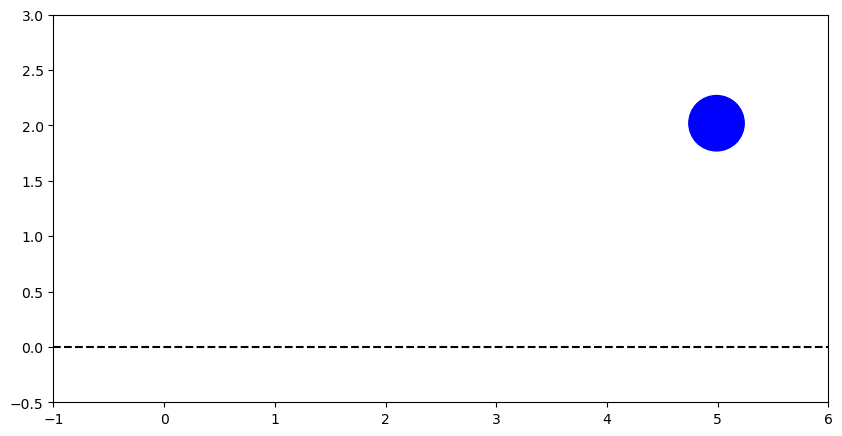

In [65]:
# Make an animation of the bouncing ball
import matplotlib.animation as animation
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.set_xlim(-1, np.max(x) + 1)
ax2.set_ylim(-0.5, y0 + 1)
ax2.axhline(0, color='black', linestyle='--', label='Ground Level')
ball = plt.Circle((0, 0), R, color='blue')
ax2.add_patch(ball)
ax2.set_aspect('equal', 'box')

def init():
    ball.center = (0, 0)
    return ball,

def animate(i):
    ball.center = (x[i], y[i])
    if y[i] < R:
        ball.set_color('red')
    else:
        ball.set_color('blue')
    return ball,

# Creating the animation and saving as a file using only every 100 frames
ani = animation.FuncAnimation(fig2, animate, init_func=init, frames=range(0, len(t_eval), 10), interval=30, blit=True)
ani.save('bouncing_ball_contact_force.mp4', writer='ffmpeg', fps=30)

Hvordan ser kraften ut som funksjon av tid? 

Vi evaluerer:
$$ F(t) = F_c(y(t) - R). $$

First bounce between t = 0.5964 s and t = 0.6302 s


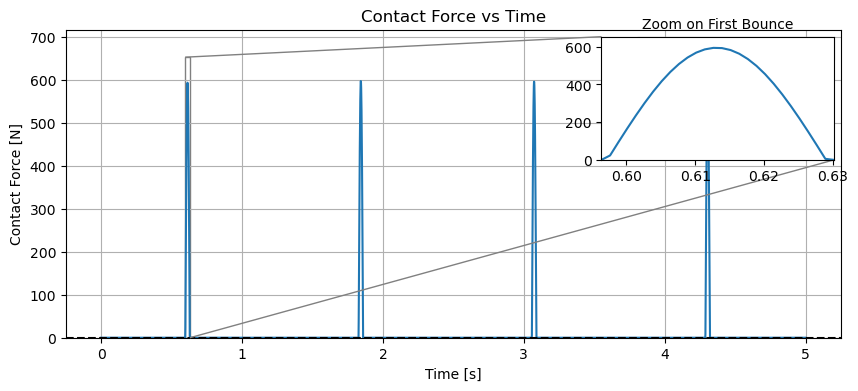

In [66]:
# Force as a function of time
F = np.array([contact_force(yi - R, k) for yi in y])
fig3, ax3 = plt.subplots(figsize=(10, 4))
ax3.plot(solution.t, F, label='Contact Force on Ball')
ax3.set_title('Contact Force vs Time')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Contact Force [N]')
ax3.axhline(0, color='black', linestyle='--')
ax3.set_ylim(0, np.max(F)*1.2)
ax3.legend()
ax3.grid()

t  = solution.t

tol = 1e-12

# Making an inset that zooms in on the first bounce
# First, locate the start of the first bounce, then locate when the force goes back to zero
bounce_indices = np.where(F > tol)[0]
first_bounce_index_0 = None
first_bounce_index_1 = None
if len(bounce_indices) > 0:
    first_bounce_index_0 = bounce_indices[0]-1  # Just before the bounce
if first_bounce_index_0 is not None:
    bounce_indices_after = np.where(F[first_bounce_index_0+1:] < tol)[0]
    if len(bounce_indices_after) > 0:
        first_bounce_index_1 = first_bounce_index_0 + 1 + bounce_indices_after[0]

t0 = t[first_bounce_index_0] if first_bounce_index_0 is not None else 0
t1 = t[first_bounce_index_1] if first_bounce_index_1 is not None else t[-1]

print(f"First bounce between t = {t0:.4f} s and t = {t1:.4f} s")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
axins = inset_axes(ax3, width="30%", height="40%", loc='upper right')
axins.plot(t, F)
axins.set_xlim(t0 - 0.0, t1 + 0.0)
axins.set_ylim(0, np.max(F[(t >= t0) & (t <= t1)])*1.1)
axins.set_title('Zoom on First Bounce', fontsize=10)
mark_inset(ax3, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

Hva blir så impulsen? 
Vi integrerer
$$ \Delta p = \int_{t_0}^{t_1} F (t) \, d t $$
fra tiden $t_0$ rett før sammenstøtet til tiden $t_1$ rett etter sammenstøtet med veggen.

In [67]:
# Integrate the force over time t \in (t0, t1) to get impulse
ids = (t >= t0) & (t <= t1)
impulse = np.trapz(F[ids], t[ids])
print(f"Impulse during first bounce: {impulse:.4f} Ns")

Impulse during first bounce: 11.9897 Ns
